In [1]:
import numpy as np
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import itertools
from tensorflow.keras.utils import to_categorical
from src.score import *
import re
from collections import OrderedDict

In [2]:
block_no = 15

In [3]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])

z = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords')
t = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').drop('level')

# For the data generator all variables have to be merged into a single dataset.
datasets = [z, t]
ds = xr.merge(datasets)

# In this notebook let's only load a subset of the training data
ds_train = ds.sel(time=slice('1979', '2016'))  
ds_test = ds.sel(time=slice('2017', '2018'))

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None, bins_z = None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            try:
                data.append(ds[var].sel(level=levels))
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time
        
        self.bins_z = np.linspace(ds.z.min(), ds.z.max(), 100) if bins_z is None else bins_z

        self.binned_data = xr.DataArray(np.digitize(ds.z, self.bins_z)-1, dims=['time', 'lat', 'lon'], coords={'time':self.data.time.values, 'lat': self.data.lat.values, 'lon': self.data.lon.values})

        del ds
        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()
        if load: print('Loading data into RAM'); self.binned_data.load()            

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.binned_data.isel(time=idxs + self.lead_time).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [5]:
# then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'z': None, 't': None})

bs=32
lead_time=72

# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1979', '2015')), dic, lead_time, batch_size=bs, load=True)

dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, bins_z = dg_train.bins_z, shuffle=False)

dg_test = DataGenerator(
    ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, bins_z = dg_train.bins_z, shuffle=False)


Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM
Loading data into RAM


In [2]:
fc = np.load('/rds/general/user/mc4117/home/WeatherBench/saved_pred/categorical_pred.npy')

In [6]:
fc_arg = fc.argmax(axis = -1)

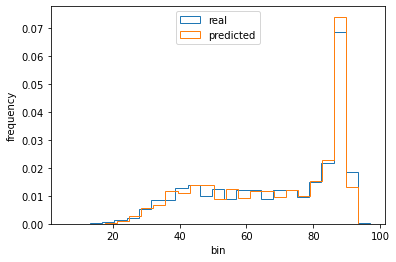

In [44]:
import pylab as plt
plt.hist(np.array(dg_test.binned_data.isel(time = slice(72, 17520))).flatten(), density = True, histtype=u'step', bins = 25, label = 'real')#, density = True, bins = 50)
plt.hist(fc_arg.flatten(), density = True, histtype=u'step', bins = 25, label = 'predicted')
plt.legend(loc = 9)
plt.xlabel('bin')
plt.ylabel('frequency')
plt.show()

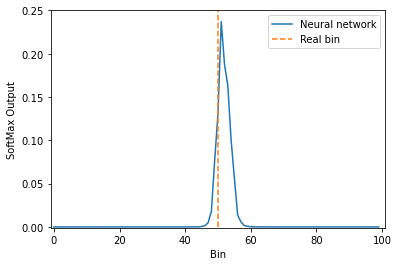

In [27]:
import pylab as plt
plt.plot(fc[0][0][0], label = 'Neural network')
plt.plot([50, 50, 50, 50, 50], [0.0, 0.05, 0.1, 0.15, 0.25], '--', label = 'Real bin')
plt.ylim([-0.001, 0.25])
plt.xlim([-1, 101])
plt.xlabel('Bin')
plt.ylabel('SoftMax Output')
plt.legend()
plt.show()

In [9]:
sum(fc[0][0][0])

0.9999999775169295

In [20]:
dg_test.binned_data[0][0][0]

<xarray.DataArray ()>
array(50)
Coordinates:
    time     datetime64[ns] 2017-01-01
    lat      float64 -87.19
    lon      float64 0.0

In [5]:
fc[0][0][0][50]

0.13112321

In [7]:
nn_pred = fc_arg[0][0][0]
fc[0][0][0][nn_pred]

0.23692429